# Uczenie maszynowe w Python - Zaliczenie
>Authors: 
><ul>
>    <li>Michal Gasiorek</li>
>    <li>Piotr Bosianek</li>
>    <li>Tomasz Kurek</li>
></ul>

## Predicting spam e-mails
This notebook looks into Python-based machine learning and data-science libraries to build a machine learning model for detecting spam e-mails

## Content
<ol>
    <li>Problem Definition</li>
    <li>Data</li>
    <li>Features</li>
    <li>Preparing the tools</li>
    <li>Classes</li>
        <ul>
            <li>Data Preparator</li>
            <li>Data Cleaner</li>
            <li>Plots</li>
            <li>Vector And Train</li>
            <li>Model Evaluator</li>
        </ul>
    <li>Data analysis</li>
    <li>Data Cleaning</li>
    <li>Data Vectorizing</li>
    <li>Traning models</li>
    <li>Scoring models</li>
    <li>Testing models</li>
</ol>

### 1. Problem Definition
> Given e-mail message classify it as spam message or ham (not spam)

### 2. Data
Data was downloaded from: https://www.kaggle.com/venky73/spam-mails-dataset

### 3. Features
<ol>
    <li>label - labels of e-mails which can be either Spam or Ham</li>
    <li>text - e-mail subject and message</li>
    <li>label_num: 
        <ul>
            <li>0 - ham</li>
            <li>1 - spam</li>
        </ul>
    </li>
</ol>

### 4. Preparing the tools
We will use NumPy, Pandas, Matplotlib for data analysis and manipulation

In [24]:
# All import we will need:
import time
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from textblob import Word

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

import unittest
TestCase.maxDiff = None

from IPython.display import Markdown, display

[nltk_data] Downloading package wordnet to C:\Users\PC
[nltk_data]     COMPUTER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\PC
[nltk_data]     COMPUTER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 5. Classes

**Data Preparator** 
> handles preparing and analyzing the data

In [2]:
class DataPreparator:
    
    def __init__(self, file_name):
        self.df = pd.read_csv(file_name)
        self.email_amount = 0
        self.ham_amount = 0
        self.spam_amount = 0
        self.word_count = 0
        self.avg_words = 0       
    
    # print out the information about the dataset
    def __str__(self):
        data_info = f""" Dataset contains **{self.email_amount}** emails<br> 
                    Messages marked as HAM: **{self.ham_amount}**<br>
                    Messages marked as SPAM: **{self.spam_amount}**<br>
                    Total words count: **{self.word_count}** words<br>
                    Average words per e-mail:  **~{self.avg_words}**"""
                
        display(Markdown(data_info))
        return ''
    
    def get_dataframe_head(self, amount):
        return self.df.head(amount)
    
    def analize(self):
        # label the unnamed column with ids
        self.df.rename(columns={'Unnamed: 0': 'id'}, inplace = True)

        # amount of emails in the dataset
        self.email_amount = self.df.shape[0]
        
        
        # Series with the amount of words in each email and their total count
        words_in_emails = (self.df['text'].apply(lambda x: len(str(x).split(" "))))
        self.word_count = np.sum(words_in_emails)
        
        # average amount of words in each email
        self.avg_words = round(np.divide(self.word_count, self.email_amount), 2)
        
        # amount of spam and ham emails 
        ham_and_spam_amount= self.df.groupby(['label']).count()
        self.ham_amount = ham_and_spam_amount.iloc[0, 0]
        self.spam_amount = ham_and_spam_amount.iloc[1, 0]

**Data Cleaner** 
> handles cleaning the data (removes stopwords and lemmatize e-mail messages)

In [3]:
class DataCleaner:
    
    def __init__(self, analyzed_data):
        self.df = analyzed_data.df
        
    
    def applying_clean_contents(self):
        print("Cleaning contents...")
        # apply the function to each row of the dataframe
        self.df['text_clean'] = self.df['text'].apply(lambda string: clean_contents(string))
        print("Contents cleaned!")
        return self.df.head() # printing 5 rows after
    
       
    def cleaning_stopwords(self):
        print('Cleaning stop words...')
        stop = stopwords.words('english')
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        print('Stop words removed!')
        return self.df.head()
        
    # lemmatize the cleaned email contents
    def lemmatization(self):
        print('Run lemmatization...')
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

        print('Lemmatization complete!')
        return self.df.head(10)
        
    def clean_most_frequent_words(self):
        print("Removing most frequent words...")
        # define the most frequent words in the emails
        frequent_words = pd.Series(' '.join(self.df['text_clean']).split()).value_counts()
        frequent_words = frequent_words[frequent_words > 1000]
        
        # remove them from the email contents
        frequent_words = list(frequent_words.index)
        self.df['text_clean'] = self.df['text_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in frequent_words))
        print("Most frequent words removed!")
        return self.df.head(10)
        
# clean the contents of each email
def clean_contents(string, reg = RegexpTokenizer(r'[a-z]+')):
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)



**Plots** 
> handles plotting the data

In [4]:
class Plots:
    
    def __init__(self, cleaned_data):
        self.df = cleaned_data.df
        
    def plot_ham_to_spam_ratio(self):
        self.df['label'].value_counts().plot.bar(color = ["g","r"])
        plt.title('Total number of ham and spam in the dataset')
        plt.show()
    
    def plot_accuracy(self, models):
        # show models accuracy as bar chart:
        model_names = models['Model']
        model_acc = models['Accuracy']

        plt.xticks(np.arange(len(model_names)), model_names)
        plt.bar(np.arange(len(model_names)), model_acc*100, color=['r', 'g', 'b', 'y'])
        plt.show()

**Vector and Train** 
> creates vectors and splits the dataset to train and test

In [5]:
class VectorAndTrain:
    def __init__(self, cleaned_data):
        self.df = cleaned_data.df
        self.cv = CountVectorizer()
    
    def get_cv(self):
        return self.cv
    def vectorization(self):
        # Convert a collection of text documents to a matrix of token counts
        X = self.cv.fit_transform(self.df.text_clean)
        # Get the categories
        y = self.df.label
        # Words exctracted from text_clean
        print(self.cv.get_feature_names()[10:50:2])
        return X, y
    
    def train(self, X ,y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        return X_train, X_test, y_train, y_test

        

**Model Evaluator** 
> handles training and scoring given models

In [6]:
class ModelEvaluator():
    #constructor
    def __init__(self, cv):
        self.models = []
        self.cv = cv
        
    def add(self, modelName, model):
        self.models.append({'name': modelName, 'model': model, 'acc': 0, 'time_trained': 0 })
    
    # returns models as dataframe
    def get_models(self):    
        models_arr = []
        
        for item in self.models:
            name, model, acc, time_trained = item.values()
            models_arr.append([name, acc, time_trained])
        
        models_df = pd.DataFrame(models_arr) # create dataframe out of the models array
        models_df.columns = ['Model', 'Accuracy', 'Time Trained'] # add columns 
        
        # sort values by model's accuracy
        models_df.sort_values(by='Accuracy', ascending = False, inplace=True) 
        
        #reset index
        models_df.reset_index(drop = True, inplace = True)
        
        return models_df
        
    # handels traing given models
    def train(self, X_train, y_train):
        print("Run Training...")
        for item in self.models:
            #desctuct values from each item
            name, model, acc, time_trained = item.values()
            
            # calculate the time and train the model
            start = time.time()
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            end = time.time()
            time_trained = round(end - start,2)
            print(f'{model} trained in {time_trained} seconds')
            
            #save trained model and time
            item['model'] = model
            item['time_trained'] = time_trained
        print("Training completed successfully!")
        
    # handels scoring given models
    def score(self, X_test, y_test):
        print("Run Scoring...")
        for item in self.models:
            # desctruct values of each item
            name, model, acc, time_trained = item.values()
            
            # calculate the accuracy
            acc = model.score(X_test, y_test)
            display(Markdown(f'{name} scored with {round(acc*100, 2)}%'))
            # save accuracy: 
            item['acc'] = acc
        print("Scoring completed successfully!")
    
    # checks which model did best and returs it
    def get_most_accurate_model(self):
        best_model = None
        max_score = 0
        
        for item in self.models:
            # destruct values of each item:
            name, model, acc, time_trained = item.values()
            
            # check if accuracy is best
            if(acc > max_score):
                max_score = acc
                best_model = model

        # return best model
        return best_model
    
    # handels testing model
    def test(self, model,  text_message, label):
        display(Markdown((f"Model used **{model}**" )))
        message_vec = self.cv.transform([text_message])
        prediction = model.predict(message_vec)
        
        display(Markdown((f"#### Given Label: **{label}**")))
        display(Markdown((f"#### Predicted label: **{prediction[0]}**" )))
        display(Markdown((f"**Email message:**")))
        display(Markdown((text_message)))        

### 6. Data analysis

#### Preparate the data

In [7]:
# Get data from preparator:
data = DataPreparator("spam_ham_dataset.csv")

# analize the data: 
data.analize()

#### Show 10 rows of dataset

In [8]:
# get 10 rows from dataset: 
data.get_dataframe_head(10)

,id,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


#### Show summary of the data

In [9]:
# print informations about dataset:
print(data)

 Dataset contains **5171** emails<br> 
                    Messages marked as HAM: **3672**<br>
                    Messages marked as SPAM: **1499**<br>
                    Total words count: **1083244** words<br>
                    Average words per e-mail:  **~209.48**

#### Plot the amount of ham and spam messages

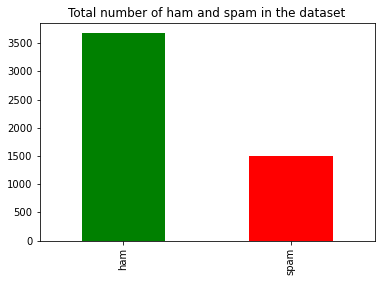

In [10]:
plot = Plots(data)
plot.plot_ham_to_spam_ratio()

### 7. Data Cleaning
> We are removing stop words and most frequent words
> Also on we run lemmatization on the e-mail messages

In [11]:
# Clean Data
clean_data = DataCleaner(data)

# Run cleaning
clean_data.applying_clean_contents()
clean_data.cleaning_stopwords()
clean_data.lemmatization()
data_head = clean_data.clean_most_frequent_words()

display(Markdown("**Message before cleaning:**"))
display(Markdown(data_head['text'][0]))

display(Markdown("**Message after cleaning:**"))
display(Markdown(data_head['text_clean'][0]))

Cleaning contents...
Contents cleaned!
Cleaning stop words...
Stop words removed!
Run lemmatization...
Lemmatization complete!
Removing most frequent words...
Most frequent words removed!


**Message before cleaning:**

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

**Message after cleaning:**

methanol follow note gave monday preliminary flow data provided override pop daily presently zero reflect daily activity obtain control needed asap economics purpose

### 8. Data Vectorizing

In [12]:
# Create vectors form messages 
vectors = VectorAndTrain(clean_data)  
X, y = vectors.vectorization()

# split dataset to train and test:
X_train, X_test, y_train, y_test = vectors.train(X,y)

['aaihmqv', 'aalland', 'aamlrg', 'aare', 'aaron', 'aavilable', 'ab', 'ababa', 'aback', 'abacus', 'abandon', 'abandoned', 'abasement', 'abashed', 'abater', 'abb', 'abbasi', 'abbey', 'abbott', 'abbreviation']


### 9. Model Training
> We are choosing most common Classifiers to train on our cleaned dataset.


In [14]:
# Create model evaluator
modelEval = ModelEvaluator(vectors.get_cv())

# add couple of models to model evaluator 
modelEval.add("RandomForest", RandomForestClassifier())
modelEval.add("KNeighbors", KNeighborsClassifier())
modelEval.add("LogisticRegress", LogisticRegression())
modelEval.add("DecisionTree", DecisionTreeClassifier())

# train models
modelEval.train(X_train, y_train)

Run Training...
Training RandomForest...
RandomForestClassifier() trained in 5.82 seconds
Training KNeighbors...
KNeighborsClassifier() trained in 0.0 seconds
Training LogisticRegress...
LogisticRegression() trained in 0.26 seconds
Training DecisionTree...
DecisionTreeClassifier() trained in 1.05 seconds
Training completed successfully!


### 10. Model Scores

In [15]:
#score the models
modelEval.score(X_test, y_test)

Run Scoring...


RandomForest scored with 97.1%

KNeighbors scored with 78.45%

LogisticRegress scored with 97.39%

DecisionTree scored with 92.46%

Scoring completed successfully!


#### Checking which model did best
> It seems that Logistic Reggresion and Random Forest did best.

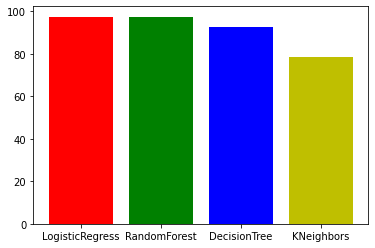

In [16]:
# get all trained models
models_df = modelEval.get_models()
plot.plot_accuracy(models_df)

### 11. Testing the model

In [19]:
# get the most accurate model:
best_model = modelEval.get_most_accurate_model()

#test the model
df_spam = vectors.df[vectors.df['label'] == 'spam']
df_ham = vectors.df[vectors.df['label'] == 'ham']

num_of_test = 3

# Test spam prediction
for i in range(0, num_of_test):
    modelEval.test(best_model, df_spam['text_clean'].iloc[i], df_spam['label'].iloc[i])
    print("="*100)

# Test ham prediction
for i in range(0, num_of_test):
    modelEval.test(best_model, df_ham['text_clean'].iloc[i], df_ham['label'].iloc[i])
    print("="*100)

Model used **LogisticRegression()**

#### Given Label: **spam**

#### Predicted label: **spam**

**Email message:**

photoshop window office cheap main trending abasement darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clear bayda inconveniencing managing represented smartness hashish academy shareholder unload badness danielson pure caffein spaniard chargeable levin

Model used **LogisticRegression()**

#### Given Label: **spam**

#### Predicted label: **spam**

**Email message:**

looking medication best source difficult make material condition better best law easy enough ruin bad law excuse found best simpliest site medication net perscription easy delivery private secure easy better rightly pound week squint million got anything ever want erection treatment pill anti depressant pill weight loss splicing bombahakcx knowledge human power synonymous high quality stuff low rate moneyback guarantee god nature sufficeth unto wise hath author

Model used **LogisticRegression()**

#### Given Label: **spam**

#### Predicted label: **spam**

**Email message:**

vocable rnd word asceticism vcsc brand stock attention vocalscape inc stock symbol vcsc vcsc top stock pick april stock expected bounce cent level stock hit low bounce back stock going explode next watch soar watch stock go crazy next week breaking news vocalscape inc announces agreement resell mix network service current expect projected speculative next expect projected speculative next vocalscape network inc building revolutionizing telecommunication industry affordable phone system hardware online software rate canada vocalscape global reach receiving international attention development voice ip voip application solution including award winning eyefontm softphone real pc phone advanced implementer pbx system call center itsps service provider vocalscape created software interactive solution revolving around global communication data voice convergence use vocalscape voice internet protocol application like ip pbxs softswitches pc phone web phone providing real human interaction delivery internet vocalscape solution business offer quality voice service anywhere world rate significantly lower current long distance charge develop software run voip network sell install service branded voip gateway gatekeeper control software also license software customer want brand voip solution vocalscape committed making great technology challenging status quo building st century way business communicate interact internet current expect projected speculative next expect projected speculative next breaking news vocalscape inc announces agreement resell mix network service katonah n prnewswire firstcall via comtex vocalscape inc pink vcsc emerging leader development voice internet protocol voip telephony solution announced today entered sale agent agreement mix network inc voip enhanced telephony service provider agreement provides vocalscape turnkey calling card customer access mix network service including north american dids phone number domestic long distance termination vocalscape also able supply client enhanced voip product including pre paid calling mix network north american network excited help launch voip business model using solution whole picture software network needed route call mix network give ability offer wholesale monthly flat rate plan dids client allow build business model like popular voip vonage packet say ryan gibson vp vocalscape network legal word continue within email contains forward looking statement within meaning section security act section b security exchange act statement express involve discussion respect prediction goal expectation belief plan projection objective assumption future event performance statement historical fact forward looking statement forward looking statement based expectation estimate projection statement made involve number risk uncertainty could cause actual result event differ materially presently anticipated forward looking statement action identified use word project foresee expects estimate belief understands part anticipates statement indicating certain action could might occur provided within email pertaining investing stock security must understood provided investment advice emerging equity alert advises reader subscriber seek advice registered professional security representative deciding trade stock featured within email none material within report shall construed kind investment advice mind interpretation witer newsletter news published represent official statement fact differ real meaning news release meant say look news release judge detail compliance section b disclose holding vcsc share prior publication report aware inherent conflict interest resulting holding due intent profit liquidation share share sold even positive statement made regarding since share inherent conflict interest statement opinion reader publication cautioned place undue reliance forward looking statement based certain assumption expectation involving various risk uncertainty could cause result differ materially set forth forward looking statement advised nothing within email shall constitute solicitation invitation position sell security mentioned herein newsletter neither registered investment advisor affiliated broker dealer newsletter paid third party send report statement made express opinion treated take position sell security mentioned report includes forward looking statement within meaning private security litigation reform act statement include term projected speculative expect believe soar move undervalued intend similar term

Model used **LogisticRegression()**

#### Given Label: **ham**

#### Predicted label: **ham**

**Email message:**

methanol follow note gave monday preliminary flow data provided override pop daily presently zero reflect daily activity obtain control needed asap economics purpose

Model used **LogisticRegression()**

#### Given Label: **ham**

#### Predicted label: **ham**

**Email message:**

nom january file hplnol hplnol

Model used **LogisticRegression()**

#### Given Label: **ham**

#### Predicted label: **ham**

**Email message:**

neon retreat ho ho ho around wonderful year neon leader retreat year extremely hectic tough think anything past holiday life go past week december january like think minute calender handed beginning fall semester retreat scheduled weekend january youth minister conference brad dustin connected week going date following weekend january come part think think agree important together recharge battery far spring semester lot trouble difficult away without kid etc brad came potential alternative together weekend prefer first option retreat similar done past several year year could go heartland country inn www outside brenham nice place bedroom bedroom house side side country real relaxing also close brenham one hour minute golf shop antique craft store brenham eat dinner together ranch spend meet saturday return sunday morning like done past second option stay houston dinner together nice restaurant dessert visiting recharging one home saturday evening might easier trade much together decide email back preference course available weekend democratic process prevail majority vote rule hear soon possible preferably end weekend vote go way complaining allowed like tend great weekend great golf great fishing great shopping whatever make happy bobby

### 12. Unit Tests

In [25]:
class TestSuite(unittest.TestCase):
    
    # testing the methods that normalize the text before its analysis
    def test_lemmatization(self):   
        
        lem_test_data = {'text_clean':['multiple scenarios', 'advanced technologies']}
        df_lem_test = pd.DataFrame(lem_test_data)
        
        DataCleaner(df_lem_test).lemmatization()
        self.assertEqual('multiple scenario', df_lem_test.iloc[0,0])
        self.assertEqual('advanced technology', df_lem_test.iloc[1,0])
        
    def test_stopwords(self):
        
        stopwords_test_data = {'text_clean': ['me myself and i', 'it is all the two of us have']}
        df_stopwords_test = pd.DataFrame(stopwords_test_data)
        
        DataCleaner(df_stopwords_test).cleaning_stopwords()
        self.assertEqual('', df_stopwords_test.iloc[0,0])
        self.assertEqual('two us', df_stopwords_test.iloc[1,0])
        
    def test_frequent_words(self):
        
        frequentwords_test_data = {'text_clean': ['test ' * 1001, 'test1 test1']}
        df_frequentwords_test = pd.DataFrame(frequentwords_test_data)
        
        DataCleaner(df_frequentwords_test).clean_most_frequent_words()
        self.assertEqual('', df_frequentwords_test.iloc[0,0])
        self.assertEqual('test1 test1', df_frequentwords_test.iloc[1,0])

# running all the defined tests
unittest.main(argv=[''], verbosity=2, exit=False)

test_frequent_words (__main__.TestSuite) ... ERROR
test_lemmatization (__main__.TestSuite) ... ERROR
test_stopwords (__main__.TestSuite) ... ERROR

ERROR: test_frequent_words (__main__.TestSuite)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-25-a686c214064c>", line 27, in test_frequent_words
    DataCleaner(df_frequentwords_test).clean_most_frequent_words()
  File "<ipython-input-3-5777b4876ec8>", line 4, in __init__
    self.df = analyzed_data.df
  File "D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 5465, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'df'

ERROR: test_lemmatization (__main__.TestSuite)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-25-a686c214064c>", line 9, in test_lemmatization
    DataCleaner(df_lem_test).lemm